In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import torch
import datetime

import sys
sys.path.append("..")
from lib.metrics import evaluate

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

DATA_PATH="../data/sz_taxi_202006/"
SEQ_LEN=5
NUM_ROADS=492

%pwd

/home/cseadmin/dz/anaconda3/envs/torch1.11/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'/home/cseadmin/dz/TrafficFlowModel/model'

data

---

In [2]:
def gen_xy(traj_list, seq_len):
    """
    Generate inputs and targets for traj next-hop prediction.
    
    Parameter
    ---
    traj_list: list of traj
    ```
    [
      [246, 0, 70, 316, 246, 0, 70],
      [265, 264, 261, 259, 255, 8, 60, 61, 111, 115, 79, 80, 81, 82, 164, 414],
      ...
    ]
    ```
    
    Returns
    ---
    x: (num_samples, seq_len)
    y: (num_samples,) 1-d vec for labels
    """
    
    x, y=[], []
    for traj in traj_list:
        for i in range(len(traj)-seq_len):
            x.append(traj[i:i+seq_len])
            y.append(traj[i+seq_len])
            
    return torch.LongTensor(x), torch.LongTensor(y)

def get_dataloaders(traj_list, seq_len, train_size=0.7, val_size=0.1, batch_size=256):
    """
    Parameters
    ---
    traj_list: list of traj
    """
    np.random.shuffle(traj_list)
    
    split1=int(len(traj_list)*train_size)
    split2=int(len(traj_list)*(train_size+val_size))
    
    train_data=traj_list[:split1]
    val_data=traj_list[split1:split2]
    test_data=traj_list[split2:]
    
    x_train, y_train=gen_xy(train_data, seq_len)
    x_val, y_val=gen_xy(val_data, seq_len)
    x_test, y_test=gen_xy(test_data, seq_len)
    
    print(f"Trainset:\tx-{x_train.size()}\ty-{y_train.size()}")
    print(f"Valset:  \tx-{x_val.size()}  \ty-{y_val.size()}")
    print(f"Testset:\tx-{x_test.size()}\ty-{y_test.size()}")
    
    trainset=torch.utils.data.TensorDataset(x_train, y_train)
    valset=torch.utils.data.TensorDataset(x_val, y_val)
    testset=torch.utils.data.TensorDataset(x_test, y_test)
    
    trainset_loader=torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
    valset_loader=torch.utils.data.DataLoader(valset, batch_size=batch_size, shuffle=True)
    testset_loader=torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)
    
    return trainset_loader, valset_loader, testset_loader

train

---

In [3]:
@torch.no_grad()
def onehot_decode(label):
    return torch.argmax(label, dim=1)

@torch.no_grad()
def accuracy(predictions, targets):
    pred_decode = onehot_decode(predictions)
    true_decode = targets

    assert (len(pred_decode) == len(true_decode))

    acc = torch.mean((pred_decode == true_decode).float())

    return float(acc)

@torch.no_grad()
def eval_model(model, valset_loader, criterion, gpu=True):
    model.eval()
    batch_loss_list=[]
    batch_acc_list=[]
    for x_batch, y_batch in valset_loader:
        if gpu and torch.cuda.is_available():
            x_batch = x_batch.cuda()
            y_batch = y_batch.cuda()

        out_batch = model.forward(x_batch)
        loss = criterion.forward(out_batch, y_batch)
        batch_loss_list.append(loss.item())
        
        acc = accuracy(out_batch, y_batch)
        batch_acc_list.append(acc)

    # return sum(batch_loss_list)/len(batch_loss_list), sum(batch_acc_list)/len(batch_acc_list)
    return np.mean(batch_loss_list), np.mean(batch_acc_list)

def train_one_epoch(model, trainset_loader, optimizer, criterion, gpu=True):
    model.train()
    batch_loss_list=[]
    batch_acc_list=[]
    for x_batch, y_batch in trainset_loader:
        if gpu and torch.cuda.is_available():
            x_batch = x_batch.cuda()
            y_batch = y_batch.cuda()

        out_batch = model.forward(x_batch)
        loss = criterion.forward(out_batch, y_batch)
        batch_loss_list.append(loss.item())
        
        acc = accuracy(out_batch, y_batch)
        batch_acc_list.append(acc)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # return sum(batch_loss_list)/len(batch_loss_list), sum(batch_acc_list)/len(batch_acc_list)
    return np.mean(batch_loss_list), np.mean(batch_acc_list)

def train(model, trainset_loader, valset_loader, optimizer, criterion, max_epochs=100, early_stop=10, verbose=1, gpu=True, plot=False, log="train.log"):
    if log:
        log=open(log, "a")
        log.seek(0)
        log.truncate()
    
    wait=0
    min_val_loss=np.inf
    
    train_loss_list=[]
    train_acc_list=[]
    val_loss_list=[]
    val_acc_list=[]
    
    for epoch in range(max_epochs):
        train_loss, train_acc=train_one_epoch(model, trainset_loader, optimizer, criterion, gpu)
        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        
        val_loss, val_acc=eval_model(model, valset_loader, criterion)
        val_loss_list.append(val_loss)
        val_acc_list.append(val_acc)
        
        if (epoch+1)%verbose==0:
            print(datetime.datetime.now(), "Epoch", epoch + 1,
                "\tTrain Loss = %.5f" % train_loss,
                "Train acc = %.5f " % train_acc,
                "Val Loss = %.5f" % val_loss,
                "Val acc = %.5f " % val_acc)
            
            if log:
                print(datetime.datetime.now(), "Epoch", epoch + 1,
                "\tTrain Loss = %.5f" % train_loss,
                "Train acc = %.5f " % train_acc,
                "Val Loss = %.5f" % val_loss,
                "Val acc = %.5f " % val_acc,
                file=log)
                log.flush()
        
        if val_loss<min_val_loss:
            wait=0
            min_val_loss=val_loss
            best_epoch=epoch
        else:
            wait+=1
            if wait >= early_stop:
                print(f"Early stopping at epoch: {epoch+1}")
                print(f"Best at epoch {best_epoch+1}:")
                print("Train Loss = %.5f" % train_loss_list[best_epoch], "Train acc = %.5f " % train_acc_list[best_epoch])
                print("Val Loss = %.5f" % val_loss_list[best_epoch], "Val acc = %.5f " % val_acc_list[best_epoch])
                
                if log:
                    print(f"Early stopping at epoch: {epoch+1}", file=log)
                    print(f"Best at epoch {best_epoch+1}:", file=log)
                    print("Train Loss = %.5f" % train_loss_list[best_epoch], "Train acc = %.5f " % train_acc_list[best_epoch], file=log)
                    print("Val Loss = %.5f" % val_loss_list[best_epoch], "Val acc = %.5f " % val_acc_list[best_epoch], file=log)
                    log.flush()
                break
        
    if plot:
        plt.plot(range(0, epoch+1), train_loss_list, "-", label="Train Loss")
        plt.plot(range(0, epoch+1), val_loss_list, "-", label="Val Loss")
        plt.title("Epoch-Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.show()
        
        plt.plot(range(0, epoch+1), train_acc_list, "-", label="Train Acc")
        plt.plot(range(0, epoch+1), val_acc_list, "-", label="Val Acc")
        plt.title("Epoch-Accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.show()
    
    if log:
        log.close()

model

---

In [19]:
class DontKnowWhat2EatNN(torch.nn.Module):
    def __init__(self, embed_dim=16, hidden_dim=64, dropout=0.0, net_type="lstm", num_layers=1, use_all_h=False, bidirectional=False):
        super(DontKnowWhat2EatNN, self).__init__()
        self.net_type=net_type
        self.use_all_h=use_all_h
        self.D=2 if bidirectional else 1
        
        self.embedding=torch.nn.Embedding(NUM_ROADS, embed_dim, padding_idx=-1) # no padding here
        
        if net_type.lower()=="lstm":
            self.rnn=torch.nn.LSTM(input_size=embed_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout, bidirectional=bidirectional)
            self.reset_lstm_params()
        elif net_type.lower()=="gru":
            self.rnn=torch.nn.GRU(input_size=embed_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout, bidirectional=bidirectional)
        elif net_type.lower()=="vanilla":
            self.rnn=torch.nn.RNN(input_size=embed_dim, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True, dropout=dropout, nonlinearity="relu", bidirectional=bidirectional)
        elif net_type.lower()=="attn":
            self.rnn=torch.nn.MultiheadAttention(embed_dim=embed_dim, num_heads=2, batch_first=True, dropout=dropout)
        else:
            print("Invalid type.")
            sys.exit(1)
        
        self.fc=torch.nn.Linear(in_features=hidden_dim*self.D, out_features=NUM_ROADS)
        self.softmax=torch.nn.Softmax(dim=1)
        
    def reset_lstm_params(self):
        for name, p in self.rnn.named_parameters():
            if "weight_ih" in name:
                torch.nn.init.xavier_uniform_(p.data)
            elif "weight_hh" in name:
                torch.nn.init.orthogonal_(p.data)
            elif "bias_ih" in name:
                p.data.fill_(0)
                # Set forget-gate bias to 1
                n = p.size(0)
                p.data[(n // 4):(n // 2)].fill_(1)
            elif "bias_hh" in name:
                p.data.fill_(0)
        
    def forward(self, x):
        # x: (batch_size, seq_len)
        out=self.embedding(x) # (batch_size, seq_len, embed_dim)
        
        if self.net_type=="attn":
            out, _=self.rnn(out, out, out) # (batch_size, seq_len, hidden_dim)
        else:
            out, _=self.rnn(out) # (batch_size, seq_len, hidden_dim)
        
        if self.use_all_h:
            out=out.contiguous().view(-1, out.shape[2]) # (batch_size*seq_len, hidden_dim) use all step's output
            out=self.fc(out) # (batch_size*seq_len, num_roads)
            out=out.view(-1, SEQ_LEN, NUM_ROADS) # (batch_size, seq_len, num_roads)
            out=out[:, -1, :] # (batch_size, num_roads)
        else:
            out=out[:, -1, :] # (batch_size, hidden_dim) use last step's output
            out=self.fc(out) # (batch_size, num_roads)
        
        out=self.softmax(out) # (batch_size, num_roads) probabilities
        
        return out
    
    def get_embed_matrix(self):
        return self.embedding.weight.cpu().numpy()

---

In [5]:
p=0.05
traj_list_all=np.load(f"../data/sz_taxi_202006/sz_taxi_202006_traj_list_bin_24_sampled_{p}_flatten_id.npy", allow_pickle=True)

len(traj_list_all)
traj_list_all[6666]

67576

[318,
 36,
 39,
 41,
 43,
 46,
 50,
 53,
 56,
 109,
 116,
 123,
 127,
 128,
 130,
 131,
 159,
 188,
 189,
 197]

tune

---

In [7]:
train_loader, val_loader, test_loader=get_dataloaders(traj_list_all, SEQ_LEN, batch_size=512)

Trainset:	x-torch.Size([658655, 5])	y-torch.Size([658655])
Valset:  	x-torch.Size([92116, 5])  	y-torch.Size([92116])
Testset:	x-torch.Size([189457, 5])	y-torch.Size([189457])


embeddding dim init: https://www.zhihu.com/question/283167457
```
2 * int(np.floor(np.power(N, 0.25)))  = 8
np.log2(N)                            = 8.94
k * np.power(N, 1/4) k<=16            = 4.71 * k
```

2022-04-24 10:17:05.017500 Epoch 1 	Train Loss = 5.95626 Train acc = 0.25650  Eval Loss = 5.79716 Eval acc = 0.40848 
2022-04-24 10:17:13.709344 Epoch 2 	Train Loss = 5.73993 Train acc = 0.46475  Eval Loss = 5.71049 Eval acc = 0.49247 
2022-04-24 10:17:22.388922 Epoch 3 	Train Loss = 5.69490 Train acc = 0.50790  Eval Loss = 5.68456 Eval acc = 0.51784 
2022-04-24 10:17:31.174992 Epoch 4 	Train Loss = 5.66045 Train acc = 0.54212  Eval Loss = 5.63813 Eval acc = 0.56421 
2022-04-24 10:17:40.550368 Epoch 5 	Train Loss = 5.62402 Train acc = 0.57839  Eval Loss = 5.60517 Eval acc = 0.59722 
2022-04-24 10:17:49.081841 Epoch 6 	Train Loss = 5.59904 Train acc = 0.60324  Eval Loss = 5.59228 Eval acc = 0.60986 
2022-04-24 10:17:58.949028 Epoch 7 	Train Loss = 5.58755 Train acc = 0.61462  Eval Loss = 5.58203 Eval acc = 0.62016 
2022-04-24 10:18:07.850817 Epoch 8 	Train Loss = 5.57505 Train acc = 0.62714  Eval Loss = 5.57101 Eval acc = 0.63108 
2022-04-24 10:18:16.907883 Epoch 9 	Train Loss = 5.56657

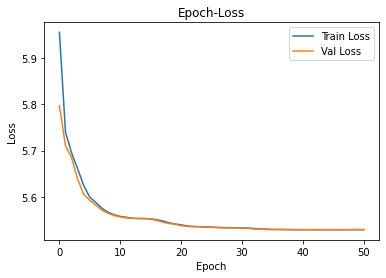

In [19]:
model=DontKnowWhat2EatNN(embed_dim=8, hidden_dim=64, net_type="lstm").cuda()
criterion=torch.nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(), lr=0.001)
train(model, train_loader, val_loader, optimizer, criterion, max_epochs=1000, early_stop=10, verbose=1, plot=True, gpu=True, log=None)

2022-04-24 10:05:51.839356 Epoch 1 	Train Loss = 6.03047 Train acc = 0.21279  Eval Loss = 5.88278 Eval acc = 0.34452 
2022-04-24 10:06:01.349952 Epoch 2 	Train Loss = 5.84140 Train acc = 0.37360  Eval Loss = 5.81023 Eval acc = 0.39997 
2022-04-24 10:06:11.304238 Epoch 3 	Train Loss = 5.78583 Train acc = 0.42265  Eval Loss = 5.76480 Eval acc = 0.44094 
2022-04-24 10:06:20.276009 Epoch 4 	Train Loss = 5.74848 Train acc = 0.45742  Eval Loss = 5.74106 Eval acc = 0.46331 
2022-04-24 10:06:29.481476 Epoch 5 	Train Loss = 5.72677 Train acc = 0.47788  Eval Loss = 5.71251 Eval acc = 0.49214 
2022-04-24 10:06:38.974592 Epoch 6 	Train Loss = 5.69743 Train acc = 0.50721  Eval Loss = 5.68796 Eval acc = 0.51629 
2022-04-24 10:06:47.972832 Epoch 7 	Train Loss = 5.66418 Train acc = 0.54068  Eval Loss = 5.65060 Eval acc = 0.55357 
2022-04-24 10:06:56.944533 Epoch 8 	Train Loss = 5.63834 Train acc = 0.56588  Eval Loss = 5.63066 Eval acc = 0.57355 
2022-04-24 10:07:05.862007 Epoch 9 	Train Loss = 5.62213

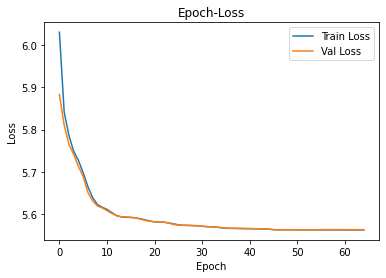

In [18]:
model=DontKnowWhat2EatNN(embed_dim=16, hidden_dim=16, net_type="lstm").cuda()
criterion=torch.nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(), lr=0.001)
train(model, train_loader, val_loader, optimizer, criterion, max_epochs=1000, early_stop=10, verbose=1, plot=True, gpu=True, log=None)

2022-04-24 10:27:04.130798 Epoch 1 	Train Loss = 5.88666 Train acc = 0.32858  Eval Loss = 5.69390 Eval acc = 0.51212 
2022-04-24 10:27:13.378445 Epoch 2 	Train Loss = 5.63243 Train acc = 0.57223  Eval Loss = 5.58305 Eval acc = 0.62070 
2022-04-24 10:27:22.200976 Epoch 3 	Train Loss = 5.56054 Train acc = 0.64272  Eval Loss = 5.54604 Eval acc = 0.65654 
2022-04-24 10:27:31.622852 Epoch 4 	Train Loss = 5.54084 Train acc = 0.66160  Eval Loss = 5.53646 Eval acc = 0.66578 
2022-04-24 10:27:40.708777 Epoch 5 	Train Loss = 5.53446 Train acc = 0.66773  Eval Loss = 5.53021 Eval acc = 0.67185 
2022-04-24 10:27:50.454889 Epoch 6 	Train Loss = 5.52917 Train acc = 0.67293  Eval Loss = 5.52865 Eval acc = 0.67340 
2022-04-24 10:27:59.281731 Epoch 7 	Train Loss = 5.52760 Train acc = 0.67446  Eval Loss = 5.52684 Eval acc = 0.67519 
2022-04-24 10:28:08.028306 Epoch 8 	Train Loss = 5.52589 Train acc = 0.67613  Eval Loss = 5.52461 Eval acc = 0.67739 
2022-04-24 10:28:17.323597 Epoch 9 	Train Loss = 5.52363

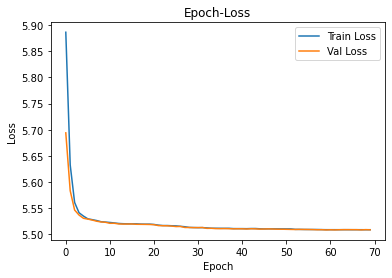

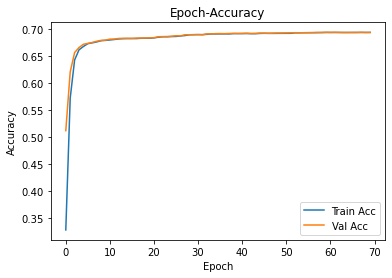

In [21]:
model=DontKnowWhat2EatNN(embed_dim=16, hidden_dim=64, net_type="lstm").cuda()
criterion=torch.nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(), lr=0.001)
train(model, train_loader, val_loader, optimizer, criterion, max_epochs=1000, early_stop=10, verbose=1, plot=True, gpu=True, log=None)

2022-04-24 10:41:24.785382 Epoch 1 	Train Loss = 5.73692 Train acc = 0.47585  Eval Loss = 5.55363 Eval acc = 0.65051 
2022-04-24 10:41:33.674782 Epoch 2 	Train Loss = 5.52681 Train acc = 0.67629  Eval Loss = 5.50825 Eval acc = 0.69425 
2022-04-24 10:41:43.496705 Epoch 3 	Train Loss = 5.50566 Train acc = 0.69661  Eval Loss = 5.50370 Eval acc = 0.69848 
2022-04-24 10:41:53.030097 Epoch 4 	Train Loss = 5.50116 Train acc = 0.70097  Eval Loss = 5.49847 Eval acc = 0.70360 
2022-04-24 10:42:02.338626 Epoch 5 	Train Loss = 5.49814 Train acc = 0.70391  Eval Loss = 5.49771 Eval acc = 0.70433 
2022-04-24 10:42:11.400058 Epoch 6 	Train Loss = 5.49761 Train acc = 0.70439  Eval Loss = 5.49670 Eval acc = 0.70535 
2022-04-24 10:42:20.678026 Epoch 7 	Train Loss = 5.49648 Train acc = 0.70553  Eval Loss = 5.49607 Eval acc = 0.70594 
2022-04-24 10:42:30.675102 Epoch 8 	Train Loss = 5.49612 Train acc = 0.70586  Eval Loss = 5.49531 Eval acc = 0.70668 
2022-04-24 10:42:40.274829 Epoch 9 	Train Loss = 5.49546

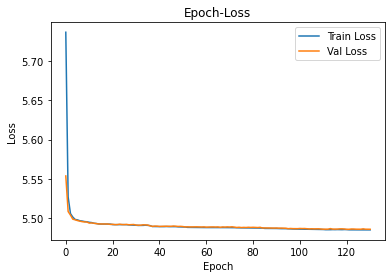

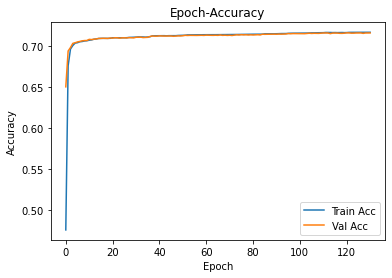

In [25]:
model=DontKnowWhat2EatNN(embed_dim=16, hidden_dim=128, net_type="lstm").cuda()
criterion=torch.nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(), lr=0.001)
train(model, train_loader, val_loader, optimizer, criterion, max_epochs=1000, early_stop=10, verbose=1, plot=True, gpu=True, log=None)

2022-04-24 11:02:45.387681 Epoch 1 	Train Loss = 5.65520 Train acc = 0.55921  Eval Loss = 5.51327 Eval acc = 0.68985 
2022-04-24 11:02:54.678589 Epoch 2 	Train Loss = 5.50491 Train acc = 0.69774  Eval Loss = 5.49970 Eval acc = 0.70256 
2022-04-24 11:03:03.982802 Epoch 3 	Train Loss = 5.49837 Train acc = 0.70382  Eval Loss = 5.49503 Eval acc = 0.70707 
2022-04-24 11:03:12.939662 Epoch 4 	Train Loss = 5.49562 Train acc = 0.70643  Eval Loss = 5.49421 Eval acc = 0.70783 
2022-04-24 11:03:21.870138 Epoch 5 	Train Loss = 5.49536 Train acc = 0.70666  Eval Loss = 5.49393 Eval acc = 0.70810 
2022-04-24 11:03:30.804965 Epoch 6 	Train Loss = 5.49493 Train acc = 0.70708  Eval Loss = 5.49374 Eval acc = 0.70824 
2022-04-24 11:03:39.690293 Epoch 7 	Train Loss = 5.49439 Train acc = 0.70759  Eval Loss = 5.49320 Eval acc = 0.70879 
2022-04-24 11:03:48.659861 Epoch 8 	Train Loss = 5.49412 Train acc = 0.70786  Eval Loss = 5.49256 Eval acc = 0.70942 
2022-04-24 11:03:57.669609 Epoch 9 	Train Loss = 5.49378

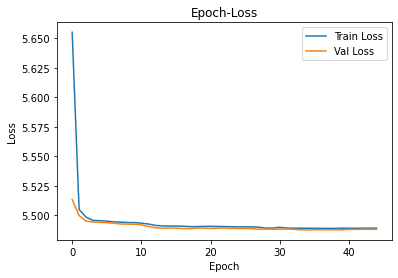

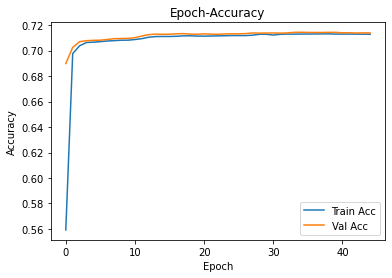

In [26]:
model=DontKnowWhat2EatNN(embed_dim=32, hidden_dim=128, net_type="lstm").cuda()
criterion=torch.nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(), lr=0.001)
train(model, train_loader, val_loader, optimizer, criterion, max_epochs=1000, early_stop=10, verbose=1, plot=True, gpu=True, log=None)

2022-04-24 11:16:02.922052 Epoch 1 	Train Loss = 5.61181 Train acc = 0.60575  Eval Loss = 5.49557 Eval acc = 0.70706 
2022-04-24 11:16:11.861849 Epoch 2 	Train Loss = 5.48901 Train acc = 0.71332  Eval Loss = 5.48543 Eval acc = 0.71680 
2022-04-24 11:16:20.715658 Epoch 3 	Train Loss = 5.48525 Train acc = 0.71685  Eval Loss = 5.48423 Eval acc = 0.71783 
2022-04-24 11:16:30.820571 Epoch 4 	Train Loss = 5.48445 Train acc = 0.71758  Eval Loss = 5.48364 Eval acc = 0.71838 
2022-04-24 11:16:39.947636 Epoch 5 	Train Loss = 5.48318 Train acc = 0.71882  Eval Loss = 5.48247 Eval acc = 0.71954 
2022-04-24 11:16:48.993745 Epoch 6 	Train Loss = 5.48251 Train acc = 0.71947  Eval Loss = 5.48231 Eval acc = 0.71968 
2022-04-24 11:16:57.938481 Epoch 7 	Train Loss = 5.48299 Train acc = 0.71900  Eval Loss = 5.48203 Eval acc = 0.71994 
2022-04-24 11:17:07.746747 Epoch 8 	Train Loss = 5.48208 Train acc = 0.71990  Eval Loss = 5.48143 Eval acc = 0.72054 
2022-04-24 11:17:17.202901 Epoch 9 	Train Loss = 5.48208

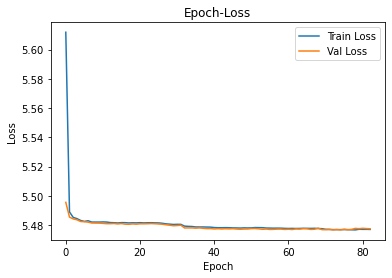

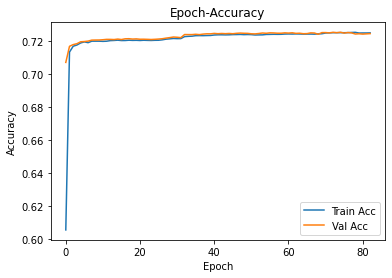

In [27]:
model=DontKnowWhat2EatNN(embed_dim=64, hidden_dim=128, net_type="lstm").cuda()
criterion=torch.nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(), lr=0.001)
train(model, train_loader, val_loader, optimizer, criterion, max_epochs=1000, early_stop=10, verbose=1, plot=True, gpu=True, log=None)

Trainset:	x-torch.Size([655839, 5])	y-torch.Size([655839])
Valset:  	x-torch.Size([94224, 5])  	y-torch.Size([94224])
Testset:	x-torch.Size([190165, 5])	y-torch.Size([190165])
2022-04-24 16:37:07.081449 Epoch 1 	Train Loss = 5.52746 Train acc = 0.68067  Eval Loss = 5.48411 Eval acc = 0.71804 
2022-04-24 16:37:34.798122 Epoch 2 	Train Loss = 5.47815 Train acc = 0.72390  Eval Loss = 5.48213 Eval acc = 0.71988 
2022-04-24 16:38:02.802909 Epoch 3 	Train Loss = 5.47770 Train acc = 0.72429  Eval Loss = 5.48204 Eval acc = 0.71994 
2022-04-24 16:38:30.689706 Epoch 4 	Train Loss = 5.47736 Train acc = 0.72462  Eval Loss = 5.48267 Eval acc = 0.71931 
2022-04-24 16:38:57.571317 Epoch 5 	Train Loss = 5.47747 Train acc = 0.72450  Eval Loss = 5.48207 Eval acc = 0.71991 
2022-04-24 16:39:24.640652 Epoch 6 	Train Loss = 5.47737 Train acc = 0.72460  Eval Loss = 5.48191 Eval acc = 0.72006 
2022-04-24 16:39:52.472917 Epoch 7 	Train Loss = 5.47689 Train acc = 0.72508  Eval Loss = 5.48032 Eval acc = 0.72165

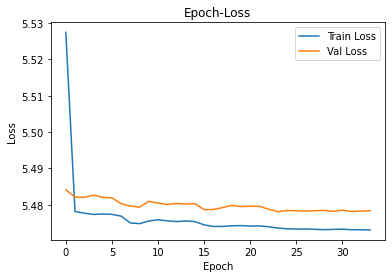

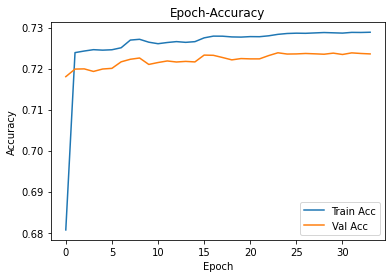

In [8]:
train_loader, val_loader, test_loader=get_dataloaders(traj_list_all, SEQ_LEN, batch_size=128)
model=DontKnowWhat2EatNN(embed_dim=64, hidden_dim=128, net_type="lstm").cuda()
criterion=torch.nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(), lr=0.001)
train(model, train_loader, val_loader, optimizer, criterion, max_epochs=1000, early_stop=10, verbose=1, plot=True, gpu=True, log=None)

Trainset:	x-torch.Size([655278, 5])	y-torch.Size([655278])
Valset:  	x-torch.Size([94281, 5])  	y-torch.Size([94281])
Testset:	x-torch.Size([190669, 5])	y-torch.Size([190669])
2022-04-25 10:26:53.331904 Epoch 1 	Train Loss = 5.77935 Train acc = 0.43913  Eval Loss = 5.65023 Eval acc = 0.55352 
2022-04-25 10:27:02.277222 Epoch 2 	Train Loss = 5.62012 Train acc = 0.58299  Eval Loss = 5.60183 Eval acc = 0.60051 
2022-04-25 10:27:11.177483 Epoch 3 	Train Loss = 5.58377 Train acc = 0.61879  Eval Loss = 5.57340 Eval acc = 0.62886 
2022-04-25 10:27:20.000656 Epoch 4 	Train Loss = 5.56649 Train acc = 0.63581  Eval Loss = 5.56255 Eval acc = 0.63961 
2022-04-25 10:27:28.835717 Epoch 5 	Train Loss = 5.55760 Train acc = 0.64456  Eval Loss = 5.55502 Eval acc = 0.64713 
2022-04-25 10:27:37.698829 Epoch 6 	Train Loss = 5.55379 Train acc = 0.64828  Eval Loss = 5.55464 Eval acc = 0.64743 
2022-04-25 10:27:46.439379 Epoch 7 	Train Loss = 5.55271 Train acc = 0.64931  Eval Loss = 5.55380 Eval acc = 0.64821

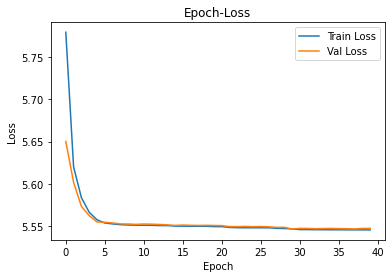

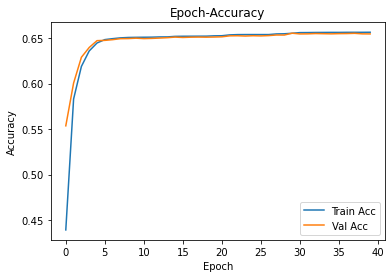

In [10]:
# relu: will be worse
train_loader, val_loader, test_loader=get_dataloaders(traj_list_all, SEQ_LEN, batch_size=512)
model=DontKnowWhat2EatNN(embed_dim=64, hidden_dim=128, net_type="lstm").cuda()
criterion=torch.nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(), lr=0.001)
train(model, train_loader, val_loader, optimizer, criterion, max_epochs=1000, early_stop=10, verbose=1, plot=True, gpu=True, log=None)

Trainset:	x-torch.Size([659197, 5])	y-torch.Size([659197])
Valset:  	x-torch.Size([91972, 5])  	y-torch.Size([91972])
Testset:	x-torch.Size([189059, 5])	y-torch.Size([189059])
2022-04-25 11:09:55.105701 Epoch 1 	Train Loss = 5.60680 Train acc = 0.61032  Eval Loss = 5.49697 Eval acc = 0.70578 
2022-04-25 11:10:04.044573 Epoch 2 	Train Loss = 5.49215 Train acc = 0.71022  Eval Loss = 5.48794 Eval acc = 0.71434 
2022-04-25 11:10:13.007504 Epoch 3 	Train Loss = 5.48781 Train acc = 0.71429  Eval Loss = 5.48701 Eval acc = 0.71506 
2022-04-25 11:10:22.143260 Epoch 4 	Train Loss = 5.48728 Train acc = 0.71474  Eval Loss = 5.48688 Eval acc = 0.71516 
2022-04-25 11:10:31.129198 Epoch 5 	Train Loss = 5.48687 Train acc = 0.71513  Eval Loss = 5.48561 Eval acc = 0.71639 
2022-04-25 11:10:40.086147 Epoch 6 	Train Loss = 5.48550 Train acc = 0.71649  Eval Loss = 5.48496 Eval acc = 0.71704 
2022-04-25 11:10:48.933904 Epoch 7 	Train Loss = 5.48496 Train acc = 0.71702  Eval Loss = 5.48473 Eval acc = 0.71726

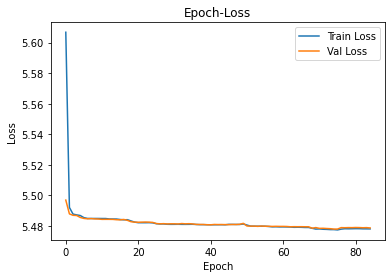

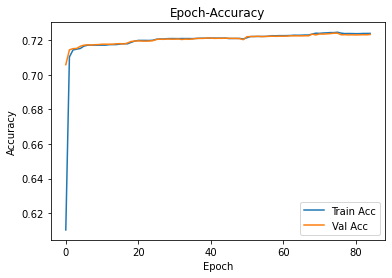

In [12]:
# use all steps' output of LSTM: 没太大区别
train_loader, val_loader, test_loader=get_dataloaders(traj_list_all, SEQ_LEN, batch_size=512)
model=DontKnowWhat2EatNN(embed_dim=64, hidden_dim=128, net_type="lstm", use_all_h=True).cuda()
criterion=torch.nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(), lr=0.001)
train(model, train_loader, val_loader, optimizer, criterion, max_epochs=1000, early_stop=10, verbose=1, plot=True, gpu=True, log=None)

Trainset:	x-torch.Size([660674, 5])	y-torch.Size([660674])
Valset:  	x-torch.Size([92107, 5])  	y-torch.Size([92107])
Testset:	x-torch.Size([187447, 5])	y-torch.Size([187447])
2022-04-25 11:36:30.436326 Epoch 1 	Train Loss = 5.80360 Train acc = 0.40507  Val Loss = 5.62117 Val acc = 0.58191 
2022-04-25 11:36:44.195429 Epoch 2 	Train Loss = 5.59249 Train acc = 0.61011  Val Loss = 5.56884 Val acc = 0.63348 
2022-04-25 11:36:57.959991 Epoch 3 	Train Loss = 5.56691 Train acc = 0.63526  Val Loss = 5.55959 Val acc = 0.64251 
2022-04-25 11:37:11.999810 Epoch 4 	Train Loss = 5.56122 Train acc = 0.64084  Val Loss = 5.55665 Val acc = 0.64543 
2022-04-25 11:37:25.664438 Epoch 5 	Train Loss = 5.55930 Train acc = 0.64272  Val Loss = 5.55596 Val acc = 0.64610 
2022-04-25 11:37:39.170449 Epoch 6 	Train Loss = 5.55793 Train acc = 0.64408  Val Loss = 5.55327 Val acc = 0.64876 
2022-04-25 11:37:52.836028 Epoch 7 	Train Loss = 5.55623 Train acc = 0.64576  Val Loss = 5.55308 Val acc = 0.64888 
2022-04-25 1

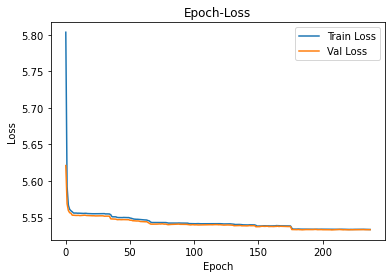

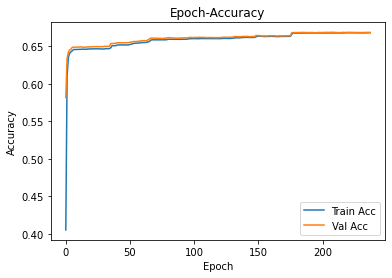

In [18]:
# 2 layer LSTM: worse
train_loader, val_loader, test_loader=get_dataloaders(traj_list_all, SEQ_LEN, batch_size=512)
model=DontKnowWhat2EatNN(embed_dim=64, hidden_dim=128, net_type="lstm", num_layers=2, use_all_h=False).cuda()
criterion=torch.nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(), lr=0.001)
train(model, train_loader, val_loader, optimizer, criterion, max_epochs=1000, early_stop=30, verbose=1, plot=True, gpu=True, log=None)

Trainset:	x-torch.Size([656709, 5])	y-torch.Size([656709])
Valset:  	x-torch.Size([94013, 5])  	y-torch.Size([94013])
Testset:	x-torch.Size([189506, 5])	y-torch.Size([189506])
2022-04-25 12:51:14.669572 Epoch 1 	Train Loss = 5.85901 Train acc = 0.34652  Val Loss = 5.80709 Val acc = 0.39546 
2022-04-25 12:51:23.584991 Epoch 2 	Train Loss = 5.73738 Train acc = 0.46482  Val Loss = 5.72352 Val acc = 0.47829 
2022-04-25 12:51:31.927494 Epoch 3 	Train Loss = 5.70210 Train acc = 0.49986  Val Loss = 5.68991 Val acc = 0.51191 
2022-04-25 12:51:40.554340 Epoch 4 	Train Loss = 5.66819 Train acc = 0.53381  Val Loss = 5.64911 Val acc = 0.55284 
2022-04-25 12:51:49.318849 Epoch 5 	Train Loss = 5.63618 Train acc = 0.56581  Val Loss = 5.62973 Val acc = 0.57221 
2022-04-25 12:51:58.166297 Epoch 6 	Train Loss = 5.62202 Train acc = 0.57999  Val Loss = 5.61600 Val acc = 0.58602 
2022-04-25 12:52:06.853205 Epoch 7 	Train Loss = 5.61080 Train acc = 0.59121  Val Loss = 5.60715 Val acc = 0.59482 
2022-04-25 1

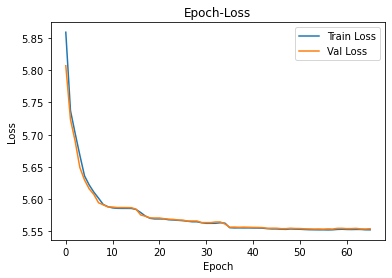

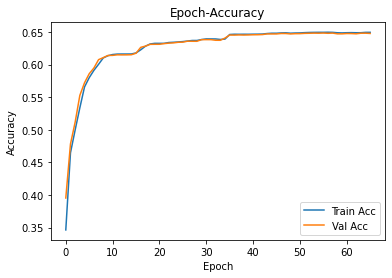

In [20]:
# vanilla RNN
train_loader, val_loader, test_loader=get_dataloaders(traj_list_all, SEQ_LEN, batch_size=512)
model=DontKnowWhat2EatNN(embed_dim=64, hidden_dim=128, net_type="vanilla", num_layers=1, use_all_lstm_h=False).cuda()
criterion=torch.nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(), lr=0.001)
train(model, train_loader, val_loader, optimizer, criterion, max_epochs=1000, early_stop=10, verbose=1, plot=True, gpu=True, log=None)

Trainset:	x-torch.Size([659822, 5])	y-torch.Size([659822])
Valset:  	x-torch.Size([93673, 5])  	y-torch.Size([93673])
Testset:	x-torch.Size([186733, 5])	y-torch.Size([186733])
2022-04-25 14:34:34.570104 Epoch 1 	Train Loss = 5.52699 Train acc = 0.68069  Val Loss = 5.48201 Val acc = 0.72006 
2022-04-25 14:35:02.593128 Epoch 2 	Train Loss = 5.47999 Train acc = 0.72205  Val Loss = 5.47832 Val acc = 0.72373 
2022-04-25 14:35:30.072474 Epoch 3 	Train Loss = 5.47943 Train acc = 0.72255  Val Loss = 5.47762 Val acc = 0.72436 
2022-04-25 14:35:58.187636 Epoch 4 	Train Loss = 5.47851 Train acc = 0.72347  Val Loss = 5.47653 Val acc = 0.72545 
2022-04-25 14:36:25.703111 Epoch 5 	Train Loss = 5.47830 Train acc = 0.72367  Val Loss = 5.47706 Val acc = 0.72491 
2022-04-25 14:36:52.905944 Epoch 6 	Train Loss = 5.47844 Train acc = 0.72353  Val Loss = 5.47669 Val acc = 0.72527 
2022-04-25 14:37:19.902360 Epoch 7 	Train Loss = 5.47816 Train acc = 0.72381  Val Loss = 5.47627 Val acc = 0.72569 
2022-04-25 1

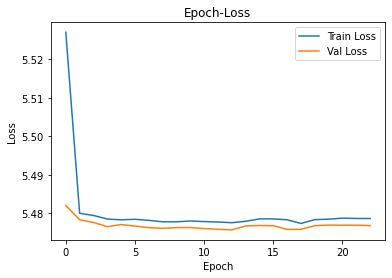

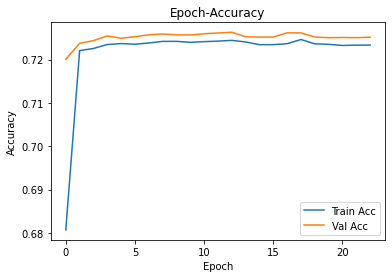

In [8]:
# 正交初始化
train_loader, val_loader, test_loader=get_dataloaders(traj_list_all, SEQ_LEN, batch_size=128)
model=DontKnowWhat2EatNN(embed_dim=64, hidden_dim=128, net_type="lstm", num_layers=1, use_all_h=False).cuda()
criterion=torch.nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(), lr=0.001)
train(model, train_loader, val_loader, optimizer, criterion, max_epochs=1000, early_stop=10, verbose=1, plot=True, gpu=True, log=None)

Trainset:	x-torch.Size([653363, 5])	y-torch.Size([653363])
Valset:  	x-torch.Size([95660, 5])  	y-torch.Size([95660])
Testset:	x-torch.Size([191205, 5])	y-torch.Size([191205])
2022-04-25 15:05:40.733248 Epoch 1 	Train Loss = 5.53907 Train acc = 0.66822  Val Loss = 5.49005 Val acc = 0.71206 
2022-04-25 15:06:07.947319 Epoch 2 	Train Loss = 5.48522 Train acc = 0.71681  Val Loss = 5.48896 Val acc = 0.71303 
2022-04-25 15:06:35.267034 Epoch 3 	Train Loss = 5.48484 Train acc = 0.71714  Val Loss = 5.48845 Val acc = 0.71351 
2022-04-25 15:07:02.826908 Epoch 4 	Train Loss = 5.48434 Train acc = 0.71764  Val Loss = 5.48789 Val acc = 0.71407 
2022-04-25 15:07:30.356090 Epoch 5 	Train Loss = 5.48369 Train acc = 0.71829  Val Loss = 5.48690 Val acc = 0.71507 
2022-04-25 15:07:57.554430 Epoch 6 	Train Loss = 5.48290 Train acc = 0.71907  Val Loss = 5.48688 Val acc = 0.71508 
2022-04-25 15:08:24.975719 Epoch 7 	Train Loss = 5.48251 Train acc = 0.71947  Val Loss = 5.48641 Val acc = 0.71555 
2022-04-25 1

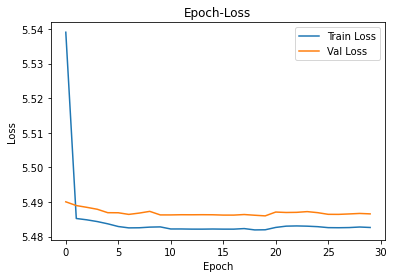

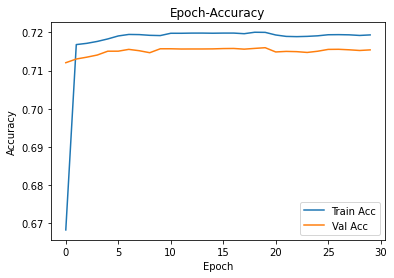

In [16]:
# 正交初始化+dropout0.1
train_loader, val_loader, test_loader=get_dataloaders(traj_list_all, SEQ_LEN, batch_size=128)
model=DontKnowWhat2EatNN(embed_dim=64, hidden_dim=128, net_type="lstm", num_layers=1, use_all_h=False, dropout=0.1).cuda()
criterion=torch.nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(), lr=0.001)
train(model, train_loader, val_loader, optimizer, criterion, max_epochs=1000, early_stop=10, verbose=1, plot=True, gpu=True, log=None)

Trainset:	x-torch.Size([654961, 5])	y-torch.Size([654961])
Valset:  	x-torch.Size([95663, 5])  	y-torch.Size([95663])
Testset:	x-torch.Size([189604, 5])	y-torch.Size([189604])
2022-04-25 15:32:19.938730 Epoch 1 	Train Loss = 5.50701 Train acc = 0.70096  Val Loss = 5.48030 Val acc = 0.72167 
2022-04-25 15:32:56.998506 Epoch 2 	Train Loss = 5.47693 Train acc = 0.72506  Val Loss = 5.47957 Val acc = 0.72240 
2022-04-25 15:33:34.343071 Epoch 3 	Train Loss = 5.47619 Train acc = 0.72578  Val Loss = 5.47908 Val acc = 0.72290 
2022-04-25 15:34:11.358580 Epoch 4 	Train Loss = 5.47650 Train acc = 0.72548  Val Loss = 5.47855 Val acc = 0.72341 
2022-04-25 15:34:51.080902 Epoch 5 	Train Loss = 5.47584 Train acc = 0.72613  Val Loss = 5.47822 Val acc = 0.72374 
2022-04-25 15:35:28.291051 Epoch 6 	Train Loss = 5.47534 Train acc = 0.72663  Val Loss = 5.47776 Val acc = 0.72421 
2022-04-25 15:36:05.965424 Epoch 7 	Train Loss = 5.47505 Train acc = 0.72692  Val Loss = 5.47777 Val acc = 0.72421 
2022-04-25 1

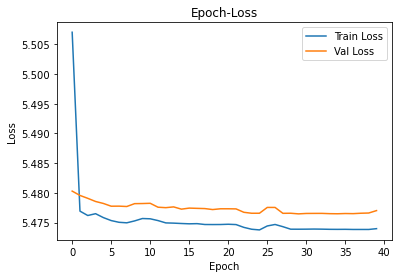

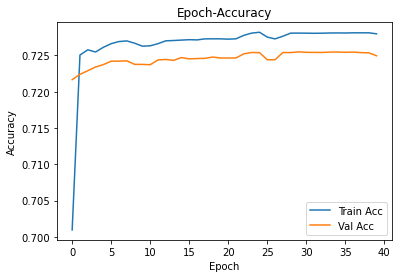

In [20]:
# 正交初始化+双向
train_loader, val_loader, test_loader=get_dataloaders(traj_list_all, SEQ_LEN, batch_size=128)
model=DontKnowWhat2EatNN(embed_dim=64, hidden_dim=128, net_type="lstm", num_layers=1, use_all_h=False, bidirectional=True).cuda()
criterion=torch.nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(), lr=0.001)
train(model, train_loader, val_loader, optimizer, criterion, max_epochs=1000, early_stop=10, verbose=1, plot=True, gpu=True, log=None)

Trainset:	x-torch.Size([658147, 5])	y-torch.Size([658147])
Valset:  	x-torch.Size([92455, 5])  	y-torch.Size([92455])
Testset:	x-torch.Size([189626, 5])	y-torch.Size([189626])
2022-04-25 15:58:27.042498 Epoch 1 	Train Loss = 5.51662 Train acc = 0.68819  Val Loss = 5.48977 Val acc = 0.71226 
2022-04-25 15:59:20.473058 Epoch 2 	Train Loss = 5.49040 Train acc = 0.71159  Val Loss = 5.48955 Val acc = 0.71242 
2022-04-25 16:00:14.367945 Epoch 3 	Train Loss = 5.49014 Train acc = 0.71183  Val Loss = 5.49002 Val acc = 0.71195 
2022-04-25 16:01:08.852460 Epoch 4 	Train Loss = 5.49049 Train acc = 0.71148  Val Loss = 5.48983 Val acc = 0.71214 
2022-04-25 16:02:08.089784 Epoch 5 	Train Loss = 5.49041 Train acc = 0.71156  Val Loss = 5.48975 Val acc = 0.71221 
2022-04-25 16:03:01.310919 Epoch 6 	Train Loss = 5.48935 Train acc = 0.71262  Val Loss = 5.48922 Val acc = 0.71275 
2022-04-25 16:04:01.370487 Epoch 7 	Train Loss = 5.48921 Train acc = 0.71276  Val Loss = 5.48915 Val acc = 0.71281 
2022-04-25 1

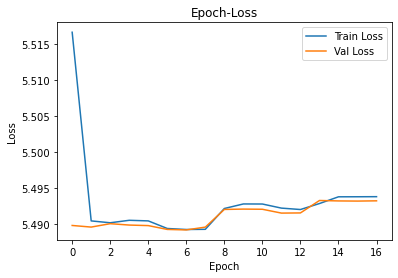

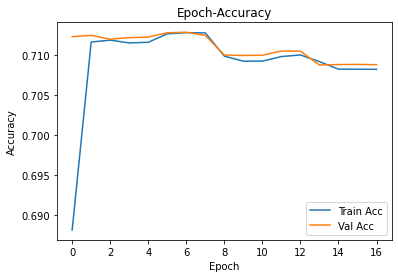

In [21]:
# 正交初始化+双向+双层
train_loader, val_loader, test_loader=get_dataloaders(traj_list_all, SEQ_LEN, batch_size=128)
model=DontKnowWhat2EatNN(embed_dim=64, hidden_dim=128, net_type="lstm", num_layers=2, use_all_h=False, bidirectional=True).cuda()
criterion=torch.nn.CrossEntropyLoss()
optimizer=torch.optim.Adam(model.parameters(), lr=0.001)
train(model, train_loader, val_loader, optimizer, criterion, max_epochs=1000, early_stop=10, verbose=1, plot=True, gpu=True, log=None)